# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Epochs, batch_size, image_size, seed

In [ ]:
epochs = 20
batch_size = 50
image_size = (256,256)
base_folder = '/content/drive/MyDrive/EYES/data'
m_folder = '/content/drive/MyDrive/EYES/data/maleeyes'
f_folder = '/content/drive/MyDrive/EYES/data/femaleeyess'
seed = 82

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Split data into train, val


In [ ]:
train_set = tf.keras.preprocessing.image_dataset_from_directory(base_folder, validation_split=0.2,
                                                               subset='training', seed=seed, image_size=image_size,
                                                               batch_size=batch_size)
val_set = tf.keras.preprocessing.image_dataset_from_directory(base_folder, validation_split=0.2,
                                                               subset='validation', seed=seed, image_size=image_size,
                                                               batch_size=batch_size)

Found 11525 files belonging to 2 classes.
Using 9220 files for training.
Found 11525 files belonging to 2 classes.
Using 2305 files for validation.


# Images

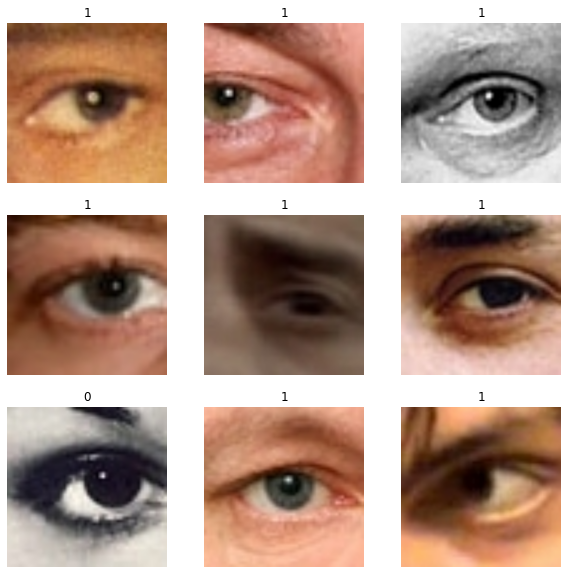

In [ ]:
plt.figure(figsize = (10,10))
for image, label in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(int(label[i]))
        plt.axis('off')

# data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Images of the eyes from different angles

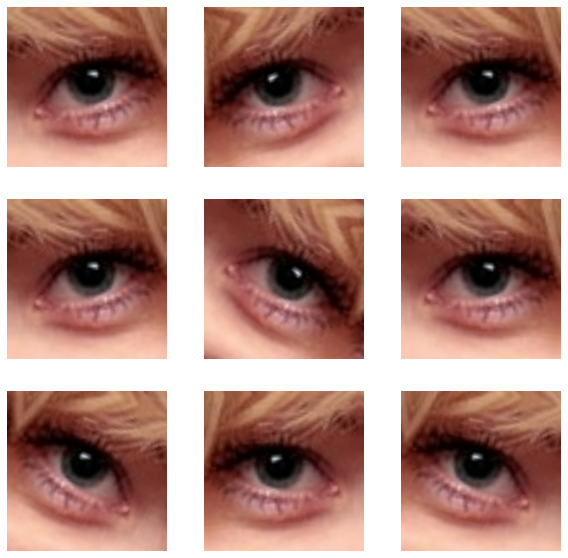

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_set.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
train_set = train_set.prefetch(buffer_size = 32)
val_set = val_set.prefetch(buffer_size = 32)

# Make the model

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)

# Callbacks

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")]
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train_set, epochs=epochs, callbacks=callbacks, validation_data=val_set)

Epoch 1/20
185/185 [==============================] - 2787s 15s/step - loss: 0.5052 - accuracy: 0.7487 - val_loss: 0.6797 - val_accuracy: 0.5553


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
185/185 [==============================] - 252s 1s/step - loss: 0.3150 - accuracy: 0.8606 - val_loss: 0.7658 - val_accuracy: 0.5553
Epoch 3/20
185/185 [==============================] - 252s 1s/step - loss: 0.2713 - accuracy: 0.8850 - val_loss: 0.4341 - val_accuracy: 0.7905
Epoch 4/20
185/185 [==============================] - 252s 1s/step - loss: 0.2448 - accuracy: 0.9022 - val_loss: 0.2202 - val_accuracy: 0.9137
Epoch 5/20
185/185 [==============================] - ETA: 0s - loss: 0.2225 - accuracy: 0.9091

KeyboardInterrupt: ignored

In [ ]:
model.save_weights('/content/drive/MyDrive/EYES')

# Predicts

In [ ]:
# Prediction function, call with /path/to/image.jpg
def predict_image(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)

    # Image needs to be in the form of a batch
    img_array = tf.expand_dims(img_array, 0)

    # Predict & score
    predictions = model.predict(img_array)
    score = predictions[0]
    print("This image is %.2f percent female and %.2f percent male." % (100 * (1 - score), 100 * score))
    plt.imshow(img);

In [ ]:
predict_image()